In [1]:
import sys

print(f"Interpreter dir: {sys.executable}")
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")
print(f"Working dir: {os.getcwd()}")
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/Stor/PdM_mockup/.venv_storpdm/bin/python3.7
Working dir: /Users/jsg/Documents/Stor/PdM_mockup


In [55]:
# General
from pathlib import Path
import warnings

# Data & modeling
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
import lightgbm as lgb
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

# Plotting
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

# Custom package
from storpdm import DATA_PATH
from storpdm.make_dataset import download_dataset, import_dataset
from storpdm.visualize import (
    visualise_sensor_correlation_all_engine,
    visualise_sensor_data_distribution,
    plot_time_history_all_engines,
    visualise_sensor_correlation_double,
    interactive_rul_series,
    actual_vs_pred
)
from storpdm.build_features import (
    find_correlated_data,
    list_correlated_data,
    find_time_independent_columns,
    add_calculated_rul,
    prepare_training_data,
)


from storpdm.train_model import EstimatorSelectionHelper

---


# Introduction

Turbofan engines are gas turbine engines often use in aircraft propulsion. In this document, we analyze data relative to such engines. The **aim** is to model and predict the Remaining Useful Life (RUL) as accurately as possible. In a real-life setup, such model can be used for:

- **Root-cause analysis**. Using machine learning models, we can analyze historical data and identify patterns or behaviors that lead to failures
- **Real-time monitoring**, generating alerts before the actual failure occurs

# Turbofan engines

The diagram below summarizes the structure of a turbofan engine: 

<img src="../reports/Turbofan_operation.svg" alt="Diagram of engine" width="500" align="center"/>

The ambient air goes though the fan and is split into the inner and outer chamber. Air goes through the Low-pressure (LPC) and High-Pressure Compressors (HPC) before combustion occurs. (TO BE FILLED)


# Problem definition

The data set consists of multiple multivariate time series. Each time series is from a different engine, i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.
    
The engine is operating normally at the start of each time series, and develops a fault at some point during the series: the fault grows in magnitude until system failure.


---

# Modeling process

The general modeling outline is described in the diagram below and is as follows:

1. Load data. In this case, data is stored in text files. Generally speaking data can be fetched from any source like xlsx files or a database
2. Pre-process data, also called data cleaning. This step is crucial to understand and trust the data. One would often iterate between:
    - Transformation: filtering, standarization, filling missing values, engineering new features
    - Visualization: graphical summary of the data helps to identify possible issues
3. Model training and selection. Here we search over different modeling approaches and select the optimal one based on relevant metrics. Techniques as cross validation and grid search for hypterparameter optimization are very useful.
4. Using the best modeling approach we do:
    - Root-cause analysis based on historical data
    - Predictions using new online data
    
<img src="../reports/data flow.svg" alt="Diagram of engine" width="1000" align="center"/>


In this notebook we model the engine failures from two different points of view, trying to answer the following questions:

> _How many cycles are left until the engine fails?_

In this case we deal with regression models

> Will the engine fail in less than 10 cycles? What is the probability?

This case falls into the category of classification modeling


# Download raw data, unzip and load to memory

Let's download the data to a local folder and unzip it


In [3]:
## Run the download function only once
if len(list(Path("data/raw").glob("train_*.txt"))) == 4:
    print("Raw data has been downloaded")
else:
    download_dataset()

Raw data has been downloaded


In [4]:
# Load datasets and display
df_rul, df_train, df_test = import_dataset(filename="FD001")
display(df_train)

id  cycle     op1     op2    op3  FanInletTemp  LPCOutletTemp  \
0        1      1 -0.0007 -0.0004  100.0        518.67         641.82   
1        1      2  0.0019 -0.0003  100.0        518.67         642.15   
2        1      3 -0.0043  0.0003  100.0        518.67         642.35   
3        1      4  0.0007  0.0000  100.0        518.67         642.35   
4        1      5 -0.0019 -0.0002  100.0        518.67         642.37   
...    ...    ...     ...     ...    ...           ...            ...   
20626  100    196 -0.0004 -0.0003  100.0        518.67         643.49   
20627  100    197 -0.0016 -0.0005  100.0        518.67         643.54   
20628  100    198  0.0004  0.0000  100.0        518.67         643.42   
20629  100    199 -0.0011  0.0003  100.0        518.67         643.23   
20630  100    200 -0.0032 -0.0005  100.0        518.67         643.85   

       HPCOutletTemp  LPTOutletTemp  FanInletPres  BypassDuctPres  \
0            1589.70        1400.60         14.62           21.61   
1            1591.82        1403.14         14.62           21.61   
2            1587.99        1404.20         14.62           21.61   
3            1582.79        1401.87         14.62           21.61   
4            1582.85        1406.22         14.62           21.61   
...              ...            ...           ...             ...   
20626        1597.98        1428.63         14.62           21.61   
20627        1604.50        1433.58         14.62           21.61   
20628        1602.46        1428.18         14.62           21.61   
20629        1605.26        1426.53         14.62           21.61   
20630        1600.38        1432.14         14.62           21.61   

       TotalHPCOutletPres  PhysFanSpeed  PhysCoreSpeed  EnginePresRatio  \
0                  554.36       2388.06        9046.19              1.3   
1                  553.75       2388.04        9044.07              1.3   
2                  554.26       2388.08        9052.94              1.3   
3                  554.45       2388.11        9049.48              1.3   
4                  554.00       2388.06        9055.15              1.3   
...                   ...           ...            ...              ...   
20626              551.43       2388.19        9065.52              1.3   
20627              550.86       2388.23        9065.11              1.3   
20628              550.94       2388.24        9065.90              1.3   
20629              550.68       2388.25        9073.72              1.3   
20630              550.79       2388.26        9061.48              1.3   

       StaticHPCOutletPres  FuelFlowRatio  CorrFanSpeed  CorrCoreSpeed  \
0                    47.47         521.66       2388.02        8138.62   
1                    47.49         522.28       2388.07        8131.49   
2                    47.27         522.42       2388.03        8133.23   
3                    47.13         522.86       2388.08        8133.83   
4                    47.28         522.19       2388.04        8133.80   
...                    ...            ...           ...            ...   
20626                48.07         519.49       2388.26        8137.60   
20627                48.04         519.68       2388.22        8136.50   
20628                48.09         520.01       2388.24        8141.05   
20629                48.39         519.67       2388.23        8139.29   
20630                48.20         519.30       2388.26        8137.33   

       BypassRatio  BurnerFuelAirRatio  BleedEnthalpy  DemandFanSpeed  \
0           8.4195                0.03            392            2388   
1           8.4318                0.03            392            2388   
2           8.4178                0.03            390            2388   
3           8.3682                0.03            392            2388   
4           8.4294                0.03            393            2388   
...            ...                 ...            ...             ...   
2

# Pre-process data and visualize

Now that the data is loaded, we do the following pre-processing:

- Remove correlated sensors. Some sensors have a correlation of "almost" 1 or -1. This means they might have different scales but their behavior is the same. Hence, we remove all the correlated sensors but one.
- Constant data with time. Some sensor like _FanInletTemp_ are constant, i.e. the sensor signal moght have gotten stuck. This sensor holds no relevant information, hence it shoudl be removed from the dataset.

After the data cleanig we visualize the distribution of the remaining features just to make sure nothings stands outs (outliers and unexpected behaviors)

In [20]:
# Reduce / Eliminate highly-correlated sensors.
correlation_threshold = 0.99
correlated_data = find_correlated_data(df_train, correlation_threshold)
columns_to_be_removed = list_correlated_data(correlated_data)

In [21]:
print(f"Removing {columns_to_be_removed} from columns")
df_train_proc = df_train.drop(columns_to_be_removed, axis=1)

Removing ['FanInletPres', 'EnginePresRatio', 'BurnerFuelAirRatio'] from columns


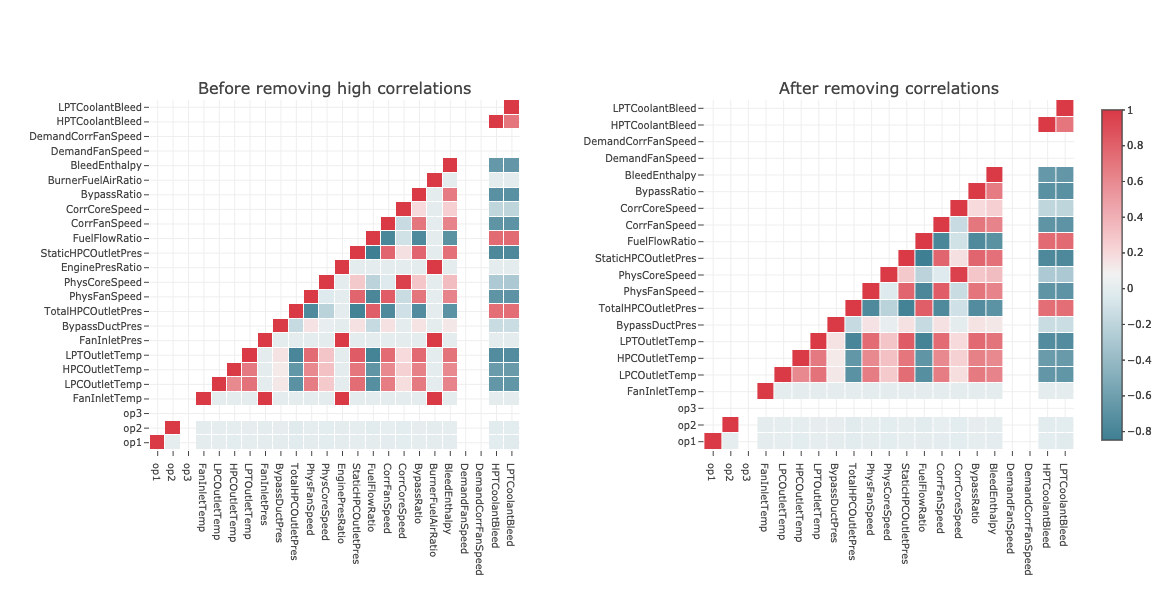

In [22]:
subplot_titles = ("Before removing high correlations", "After removing correlations")
fig = visualise_sensor_correlation_double(df_train, df_train_proc, subplot_titles)
fig.show()

On the left plot, we observe that some features are hihgly correlated. On the right plot we confirm they have been remove

Next, let's plot the distribution of the sensor data.

<Figure size 1080x1080 with 0 Axes>

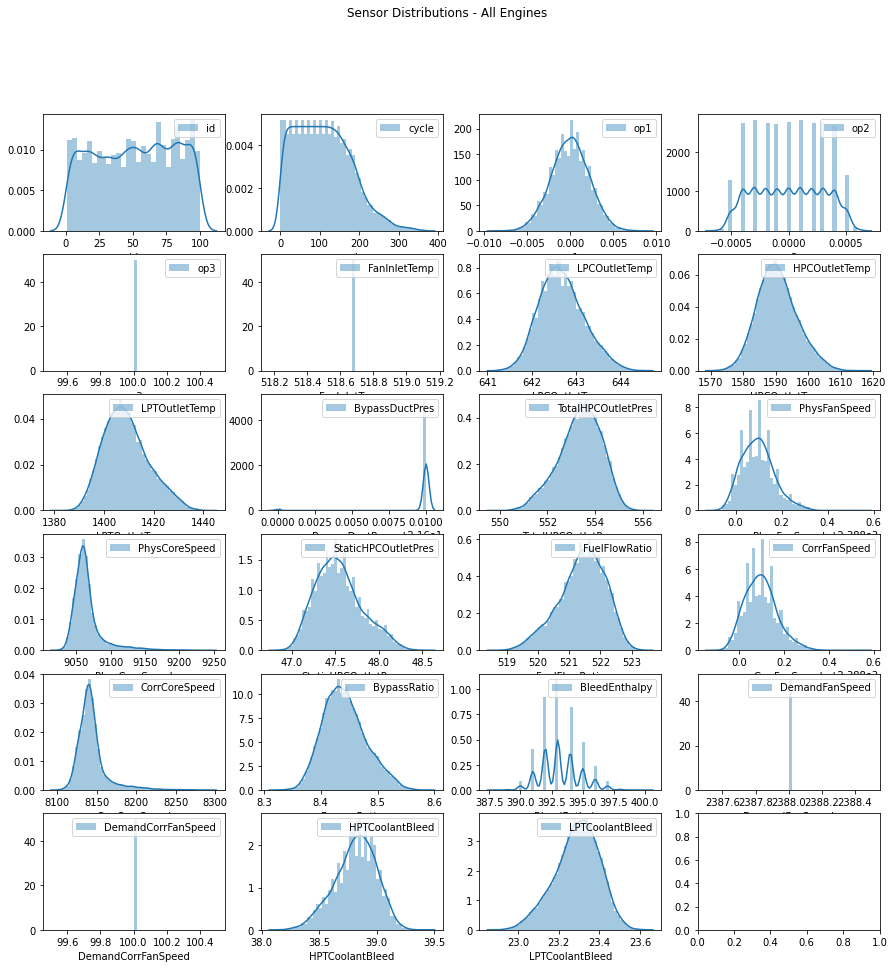

In [16]:
plt.figure(figsize=(15, 15))
with warnings.catch_warnings(record=True):
    fig = visualise_sensor_data_distribution(df_train_proc)

It seems like some values are constant. We could have guessed this by looking at the raw table. We clean those too.

In [24]:
# Find columns that does not change with time.
time_independent_columns = find_time_independent_columns(df_train_proc)

print(f"Removing constant columns: {time_independent_columns}")
df_train_proc2 = df_train_proc.drop(time_independent_columns, axis=1)

# Add Remaining Useful Life (RUL) to dataset.
df_train_proc2 = add_calculated_rul(df_train_proc2)

display(df_train_proc2)

Removing constant columns: ['op3', 'FanInletTemp', 'BypassDuctPres', 'PhysFanSpeed', 'CorrFanSpeed', 'DemandFanSpeed', 'DemandCorrFanSpeed']


id  cycle     op1     op2  LPCOutletTemp  HPCOutletTemp  \
0        1      1 -0.0007 -0.0004         641.82        1589.70   
1        1      2  0.0019 -0.0003         642.15        1591.82   
2        1      3 -0.0043  0.0003         642.35        1587.99   
3        1      4  0.0007  0.0000         642.35        1582.79   
4        1      5 -0.0019 -0.0002         642.37        1582.85   
...    ...    ...     ...     ...            ...            ...   
20626  100    196 -0.0004 -0.0003         643.49        1597.98   
20627  100    197 -0.0016 -0.0005         643.54        1604.50   
20628  100    198  0.0004  0.0000         643.42        1602.46   
20629  100    199 -0.0011  0.0003         643.23        1605.26   
20630  100    200 -0.0032 -0.0005         643.85        1600.38   

       LPTOutletTemp  TotalHPCOutletPres  PhysCoreSpeed  StaticHPCOutletPres  \
0            1400.60              554.36        9046.19                47.47   
1            1403.14              553.75        9044.07                47.49   
2            1404.20              554.26        9052.94                47.27   
3            1401.87              554.45        9049.48                47.13   
4            1406.22              554.00        9055.15                47.28   
...              ...                 ...            ...                  ...   
20626        1428.63              551.43        9065.52                48.07   
20627        1433.58              550.86        9065.11                48.04   
20628        1428.18              550.94        9065.90                48.09   
20629        1426.53              550.68        9073.72                48.39   
20630        1432.14              550.79        9061.48                48.20   

       FuelFlowRatio  CorrCoreSpeed  BypassRatio  BleedEnthalpy  \
0             521.66        8138.62       8.4195            392   
1             522.28        8131.49       8.4318            392   
2             522.42        8133.23       8.4178            390   
3             522.86        8133.83       8.3682            392   
4             522.19        8133.80       8.4294            393   
...              ...            ...          ...            ...   
20626         519.49        8137.60       8.4956            397   
20627         519.68        8136.50       8.5139            395   
20628         520.01        8141.05       8.5646            398   
20629         519.67        8139.29       8.5389            395   
20630         519.30        8137.33       8.5036            396   

       HPTCoolantBleed  LPTCoolantBleed  RUL  
0                39.06          23.4190  191  
1                39.00          23.4236  190  
2                38.95          23.3442  189  
3                38.88          23.3739  188  
4                38.90          23.4044  187  
...                ...              ...  ...  
20626            38.49          22.9735    4  
20627            38.30          23.1594    3  
20628            38.44          22.9333    2  
20629            38.29          23.0640    1  
20630            38.37          23.0522    0  

[20631 rows x 17 columns]

The table above is clean and reasy to be used. Let's visualize some of the time series separately. Onthe X axis, we show the Remaining Useful Life (RUL). As we approach RUL=0 it means the engine is about to fail.

On the graph below, select the variable to plot in the dropdown menu. Variable `PhysCoreSpeed` seems quite relevant, as its values diverge as the RUL decreases.

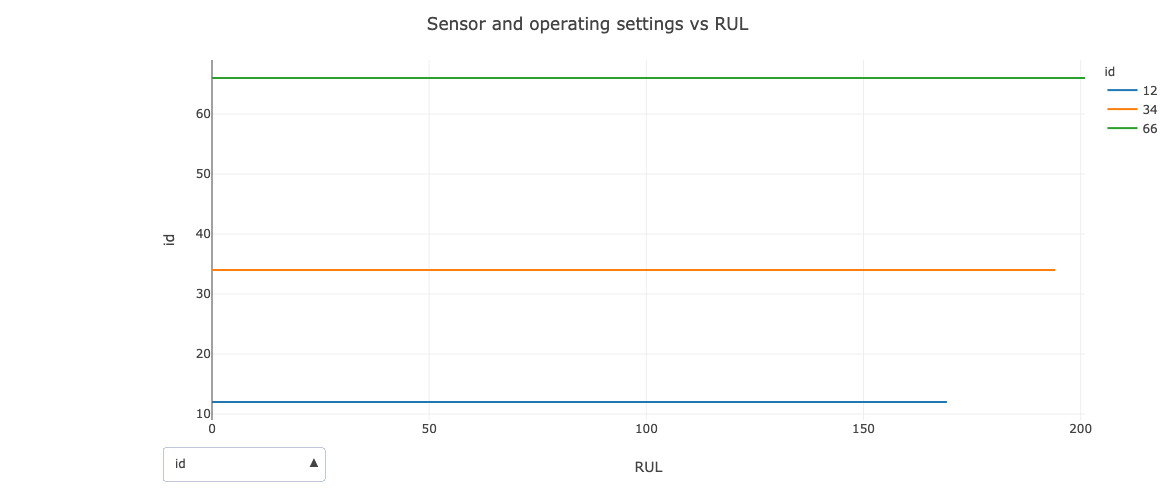

In [25]:
fig = interactive_rul_series(df_train_proc2, id_filter=[66, 12, 34])
fig.show()

# Find best model and train

We perform a comparison of 3 different models with several combinations of hyperparameters and automatically select the best one:

1. Linear model with lasso penalization
2. Gradient boosted regression trees
3. Neural network: Multi-Layer Perceptron (MLP) regressor. 

When selecting a model, we respect the principles of cross-validation to avoid overfitting.

In [32]:
# Define models
models = {
    "linear": Ridge(normalize=True),
    "lgb": lgb.LGBMRegressor(),
    "mlp": Pipeline(
        [("std", MinMaxScaler()), ("m1", MLPRegressor(early_stopping=True))]
    ),
}

# Define hyperparam search space
params = {
    "linear": {},
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth": [5, 10, 15, 20],
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128), (64, 32)],
        "m1__learning_rate_init": [0.001, 0.005, 0.01],
    },
}

In [33]:
# Split train and test
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL", discard_cols="id"
)

In [34]:
%%time
estim_grid = EstimatorSelectionHelper(models, params)
estim_grid.fit(
    X_train, y_train, scoring="neg_root_mean_squared_error", n_jobs=2, cv=None
)

Running GridSearchCV for linear.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   39.6s finished


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  2.2min finished


CPU times: user 17.4 s, sys: 1.89 s, total: 19.3 s
Wall time: 2min 59s


Below we show the top 5 models. Gradient boosted regression trees is the winner model

In [39]:
model = estim_grid.best_model
print(f"Winner model: {model}")

print(f"Total number of models: {estim_grid.score_summary().shape[0]}")
estim_grid.score_summary().head()

Winner model: LGBMRegressor(learning_rate=0.01, max_depth=20, n_estimators=500)
Total number of models: 23


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       1.172096      0.172779         0.054801        0.008133   
13       1.179026      0.049401         0.047632        0.000913   
9        0.912474      0.067319         0.043719        0.000558   
11       1.213656      0.084573         0.052127        0.004760   
5        4.725470      1.382821         0.007299        0.000979   

                                               params  split0_test_score  \
15  {'learning_rate': 0.01, 'max_depth': 20, 'n_es...         -36.085727   
13  {'learning_rate': 0.01, 'max_depth': 15, 'n_es...         -36.106520   
9   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         -36.193871   
11  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...         -36.101462   
5   {'m1__hidden_layer_sizes': (64, 32), 'm1__lear...         -36.300794   

    split1_test_score  split2_test_score  split3_test_score  \
15         -36.026132         -35.596279         -37.287655   
13         -36.029922         -35.579115         -37.291051   
9          -35.995038         -35.522113         -37.279388   
11         -36.011962         -35.598674         -37.273967   
5          -35.839264         -35.835841         -37.050936   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
15         -35.836283       -36.166415        0.586073                1   
13         -35.844181       -36.170158        0.589187                2   
9          -35.861670       -36.170416        0.596112                3   
11         -35.866133       -36.170440        0.577436                4   
5          -36.043719       -36.214111        0.451757                1   

    split0_train_score  split1_train_score  split2_train_score  \
15          -32.142465          -32.193598          -32.205210   
13          -32.171451          -32.197594          -32.200700   
9           -33.538418          -33.570205          -33.571423   
11          -32.248436          -32.253799          -32.335444   
5           -36.252102          -35.885289          -36.435708   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  \
15          -31.863161          -32.120410        -32.104969         0.124915   
13          -31.848941          -32.125479        -32.108833         0.132710   
9           -33.170582          -33.464165        -33.462958         0.151292   
11          -31.960118          -32.210960        -32.201751         0.127463   
5           -35.489394          -36.336759        -36.079850         0.348941   

   model param_learning_rate param_max_depth param_n_estimators  \
15   lgb                0.01              20                500   
13   lgb                0.01              15                500   
9    lgb                0.01               5                500   
11   lgb                0.01              10                500   
5    mlp                 NaN             NaN                NaN   

   param_m1__hidden_layer_sizes param_m1__learning_rate_init  
15                          NaN                          NaN  
13                          NaN                          NaN  
9                           NaN                          NaN  
11                          NaN                          NaN  
5                      (64, 32)                         0.01

In [40]:
y_test_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Random Forest Regression test MAE: {mae:.3f}")
print(f"Random Forest Regression test RMSE: {rmse:.3f}")

Random Forest Regression test MAE: 24.974
Random Forest Regression test RMSE: 35.333


The "test" error is what we cna expect to see on new unseen data.

# Root-cause analysis. Model diagnostics and interpretation

Let's draw the actual RUL versus the predictions. On the left scatter plot, ideally, they should be equal (i.e. represented by the diagonal line). Generally speaking, the points of clouds is proportional to the magnitude of the remaining useful life.

On the right plot we show the actual vs predicted RUL for a selecion of couple of engines.

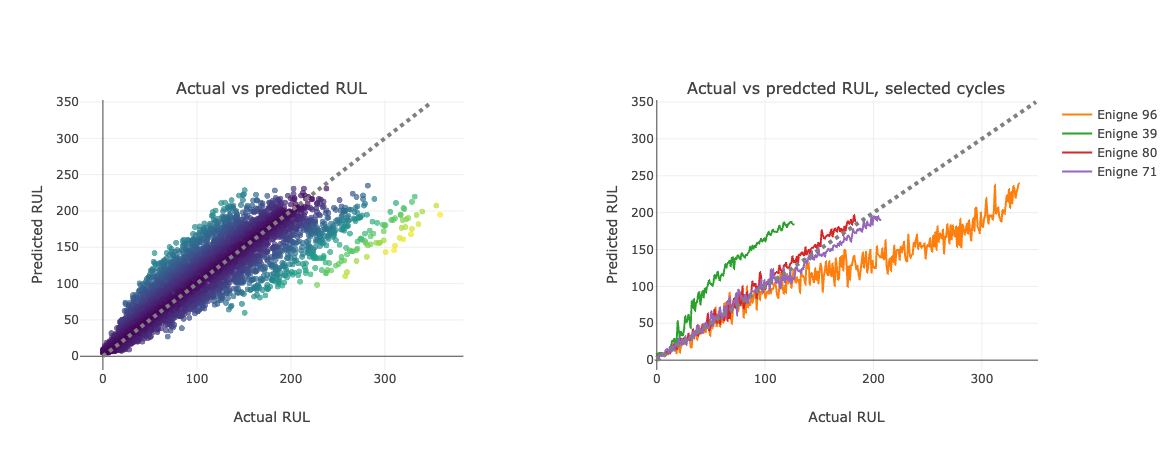

In [59]:
actual_vs_pred(model, X_test, y_test, df_train_proc2)

Next, we analyze the trained model and infer how each of the sensors contribute to the decrease of RUL. Conclusions are stated at the bottoom.

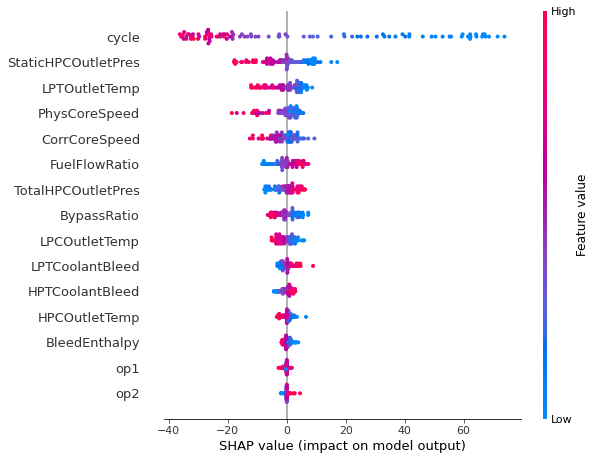

In [61]:
# TODO: Shap feature importance ---> FIXME
import shap

data_shap = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(model.predict, data=data_shap)

X_sample = X_train.sample(100)
with warnings.catch_warnings(record=True):
    shap_values = explainer.shap_values(X_sample, l1_reg="num_features(100)")

# summarize the effects of all the features
shap.summary_plot(shap_values, X_sample)

From the SHAP plot above we conclude that:

- Features are sorted in order of relevance from top to bottom
- Higher values of cycle (highligthed in red) are associated with lower RUL. This makes a lot of sense: the longer the engine has been running, the closest it is to failure
- The second most important feature if `StaticHPCOutletPres`: higer values of pressure indicate lower RUL

Similar conclusions are drawn from the Partiap Dependence PLots (PDP) below.

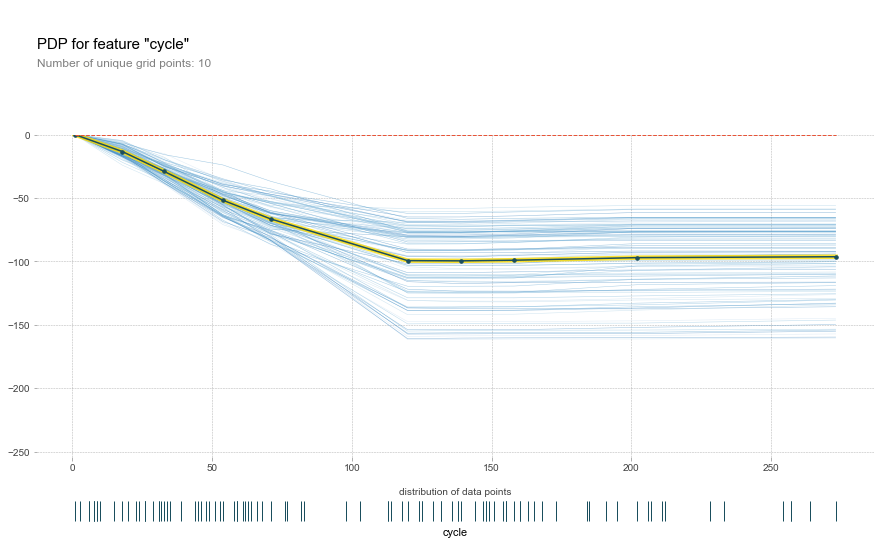

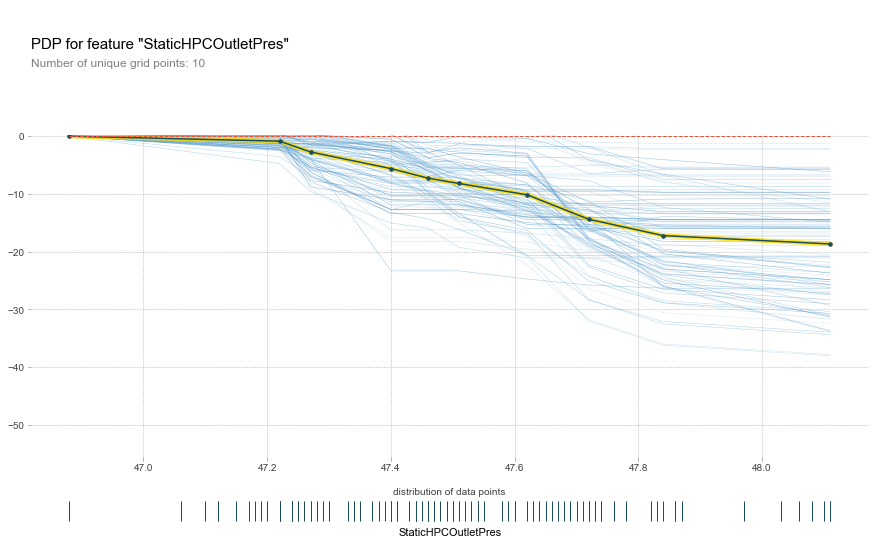

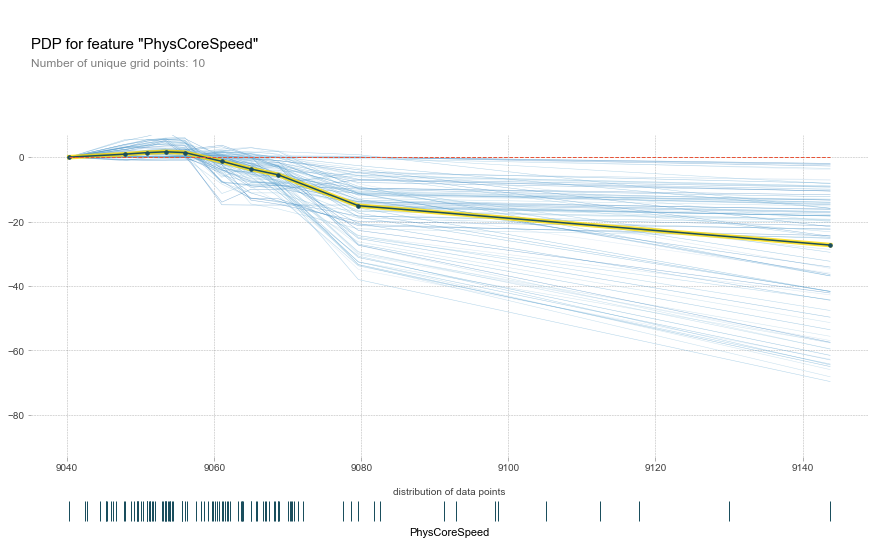

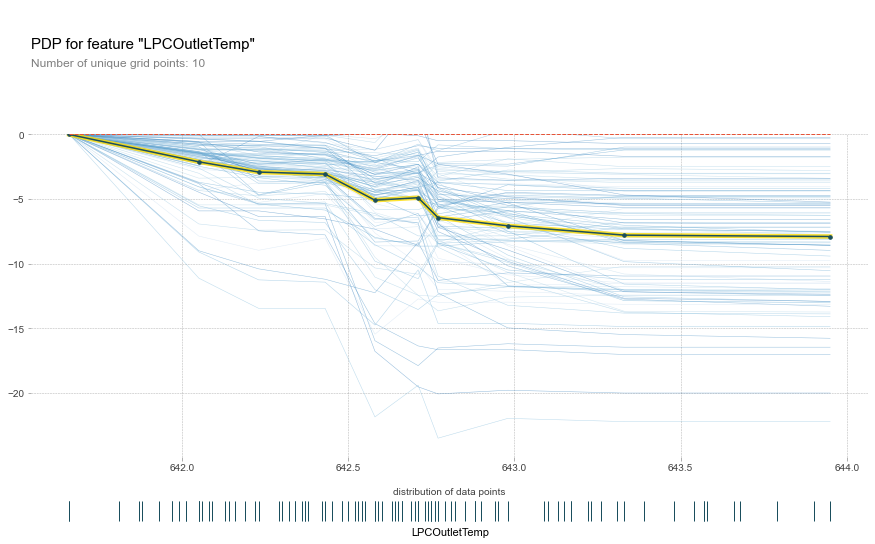

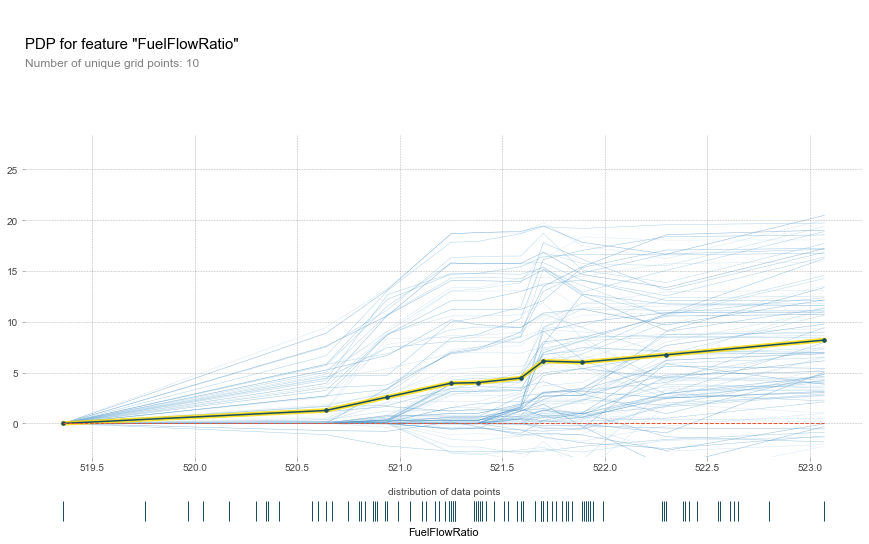

In [27]:
from pdpbox import pdp, get_dataset, info_plots

features = [
    "cycle",
    "StaticHPCOutletPres",
    "PhysCoreSpeed",
    "LPCOutletTemp",
    "FuelFlowRatio",
]

for f in features:

    pdp_goals = pdp.pdp_isolate(
        model=model, dataset=X_sample, model_features=X_train.columns, feature=f
    )
    pdp.pdp_plot(
        pdp_goals, f, x_quantile=False, plot_pts_dist=True, plot_lines=True, center=True
    )


---

# Classification model

## Will the engine fail in less than 10 cycles? With what probability?

In [99]:
cycle_threshold = 10
df_train_proc2["RUL_thres"] = np.where(df_train_proc2["RUL"] <= cycle_threshold, 1, 0)

In [29]:
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Define models
models = {
    # "rf": RandomForestRegressor(), # 3 minutes
    "lgb": lgb.LGBMClassifier(),
    "logistic": LogisticRegression(max_iter=300),
    "mlp": Pipeline(
        [("std", MinMaxScaler()), ("m1", MLPClassifier(early_stopping=True))]
    ),
}

# Define hyperparam search space
params = {
    # "rf": {"n_estimators": [100, 500]},
    "lgb": {
        "n_estimators": [100, 500],
        "learning_rate": [0.005, 0.01],
        "max_depth": [5, 10, 15, 20],
    },
    "mlp": {
        "m1__hidden_layer_sizes": [(128), (64, 32)],
        "m1__learning_rate_init": [0.001, 0.005, 0.01],
    },
    "logistic": {},
}

In [30]:
X_train, X_test, y_train, y_test = prepare_training_data(
    df=df_train_proc2, target_col="RUL_thres", discard_cols=["id", "RUL"]
)

In [45]:
%%time
estim_grid_clf = EstimatorSelectionHelper(models, params)
estim_grid_clf.fit(X_train, y_train, scoring="f1", n_jobs=2, cv=None)

Running GridSearchCV for lgb.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   25.5s finished


Running GridSearchCV for logistic.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


Running GridSearchCV for mlp.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   31.7s finished


CPU times: user 13.4 s, sys: 1.11 s, total: 14.5 s
Wall time: 1min


In [46]:
estim_grid_clf.score_summary().head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       0.773288      0.078503         0.031086        0.003243   
9        0.681190      0.077034         0.035963        0.000900   
13       0.830603      0.033889         0.031876        0.001241   
3        2.492965      0.212066         0.010478        0.002431   
11       0.812212      0.019677         0.034056        0.001473   

   param_learning_rate param_max_depth param_n_estimators  \
15                0.01              20                500   
9                 0.01               5                500   
13                0.01              15                500   
3                  NaN             NaN                NaN   
11                0.01              10                500   

                                               params  split0_test_score  \
15  {'learning_rate': 0.01, 'max_depth': 20, 'n_es...           0.842105   
9   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...           0.849711   
13  {'learning_rate': 0.01, 'max_depth': 15, 'n_es...           0.835294   
3   {'m1__hidden_layer_sizes': (64, 32), 'm1__lear...           0.823864   
11  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...           0.835294   

    split1_test_score  split2_test_score  split3_test_score  \
15           0.836158           0.820809           0.807910   
9            0.828571           0.821530           0.800000   
13           0.825843           0.815029           0.804533   
3            0.841499           0.813754           0.803468   
11           0.821530           0.811594           0.801136   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
15           0.821114         0.825619        0.012165                1   
9            0.816327         0.823228        0.016248                2   
13           0.810651         0.818270        0.010995                3   
3            0.803519         0.817221        0.014300                1   
11           0.814159         0.816743        0.011347                4   

    split0_train_score  split1_train_score  split2_train_score  \
15            0.993612            0.990774            0.994318   
9             0.923843            0.923735            0.930466   
13            0.992193            0.990071            0.995025   
3             0.819088            0.815847            0.814224   
11            0.985117            0.984353            0.991465   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  \
15            0.995733            0.995733          0.994034         0.001825   
9             0.932384            0.927350          0.927556         0.003470   
13            0.995018            0.996441          0.993750         0.002299   
3             0.825581            0.824121          0.819772         0.004457   
11            0.985755            0.988604          0.987059         0.002630   

   model param_m1__hidden_layer_sizes param_m1__learning_rate_init  
15   lgb                          NaN                          NaN  
9    lgb                          NaN                          NaN  
13   lgb                          NaN                          NaN  
3    mlp                     (64, 32)                        0.001  
11   lgb                          NaN                          NaN

In [47]:
model = estim_grid_clf.best_model
y_test_pred = model.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print(f"F1 score test: {f1:.3f}")

F1 score test: 0.831


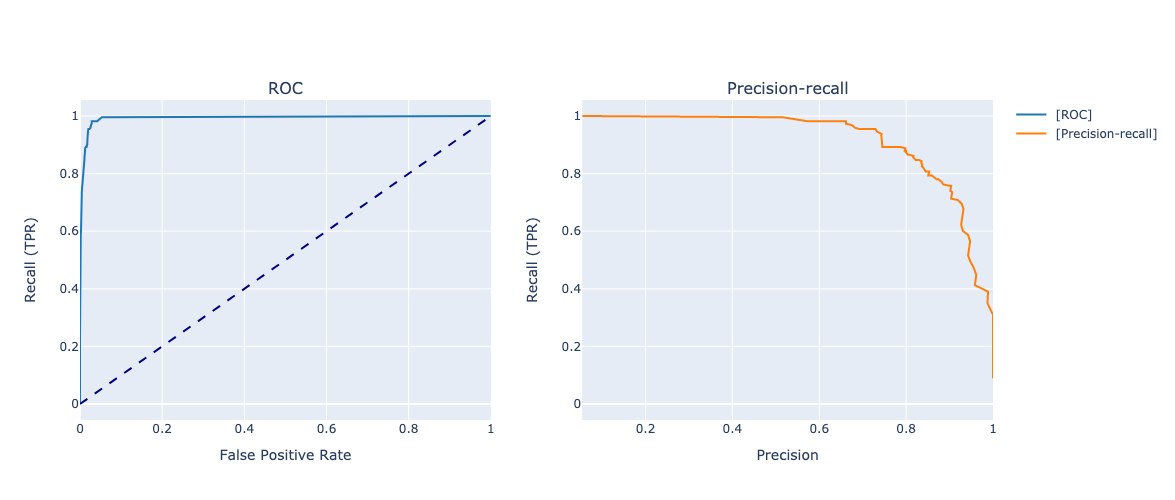

In [35]:
from storpdm.utils import metrics_threshold
from storpdm.build_features import prepare_training_data
from storpdm.visualize import display_roc_pr

y_score = model.predict_proba(X_test)
metrics = metrics_threshold(y_score[:, 1], y_test)

display_roc_pr(
    precision=metrics["prec"],
    recall=metrics["rec"],
    fpr=metrics["fpr"],
    thres=metrics["thres"],
)

In [37]:
# TODO: display table too
display(
    pd.DataFrame(
        {
            "thresholds": metrics["thres"],
            "precision": metrics["prec"],
            "recall": metrics["rec"],
            "fpr": np.round(metrics["fpr"], 3),
            "TP": metrics["tp"],
            "TN": metrics["tn"],
            "FP": metrics["fp"],
            "FN": metrics["fn"],
        }
    )
    .loc[::10]
    .loc[::-1]
)

thresholds  precision    recall    fpr   TP    TN    FP   FN
100         1.0        NaN  0.000000  0.000    0  3904     0  223
90          0.9   0.961538  0.448430  0.001  100  3900     4  123
80          0.8   0.928105  0.636771  0.003  142  3893    11   81
70          0.7   0.901639  0.739910  0.005  165  3886    18   58
60          0.6   0.866337  0.784753  0.007  175  3877    27   48
50          0.5   0.836364  0.825112  0.009  184  3868    36   39
40          0.4   0.817021  0.860987  0.011  192  3861    43   31
30          0.3   0.786561  0.892377  0.014  199  3850    54   24
20          0.2   0.743772  0.937220  0.018  209  3832    72   14
10          0.1   0.691558  0.955157  0.024  213  3809    95   10
0           0.0   0.054034  1.000000  1.000  223     0  3904    0

First we define the following metrics:

- Precision: fraction of predictions were correct
- False positive rate: fraction of times we predict a failure and then it is not
- Recall: fraction of failures were predicted. Amongst all failures, how many do we predict correctly?
- Threshold translates probability of failure to a binary variable.

Looking at the ROC-Precision graph above, we can choose an optimal **threshold** based on the business needs.

A higher threshold (for example, 0.8) means there fpr is 0.003, 0.928 precision and 0.637 recall. This means we are very confident of our predictions but 0.363% of the failures we miss. This threshold is optimal if the cost 

Let's look at the confusion matrix with a threshold of 0.5:


Confusion matrix before normalization
[[3868   36]
 [  39  184]]
Normalized confusion matrix


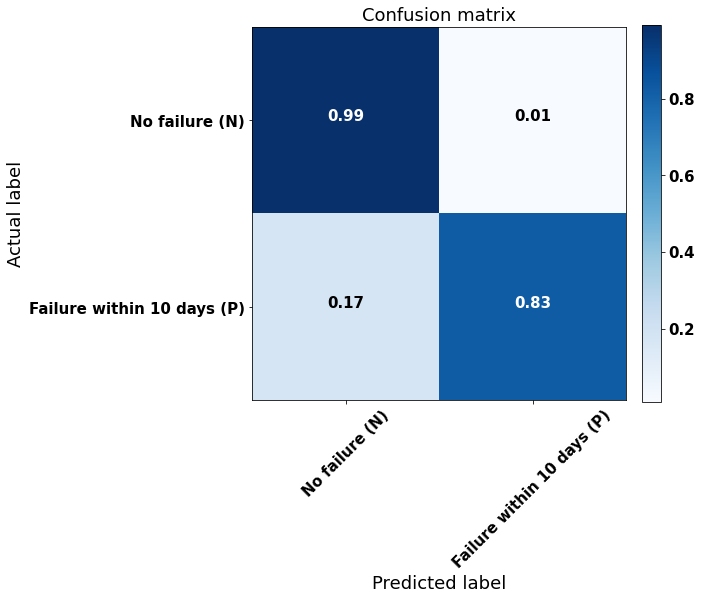

In [39]:
from storpdm.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(
    confusionMatrix,
    normalize=True,
    classes=["No failure (N)", "Failure within 10 days (P)"],
)

Confusion matrix before normalization
[[3868   36]
 [  39  184]]
Normalized confusion matrix


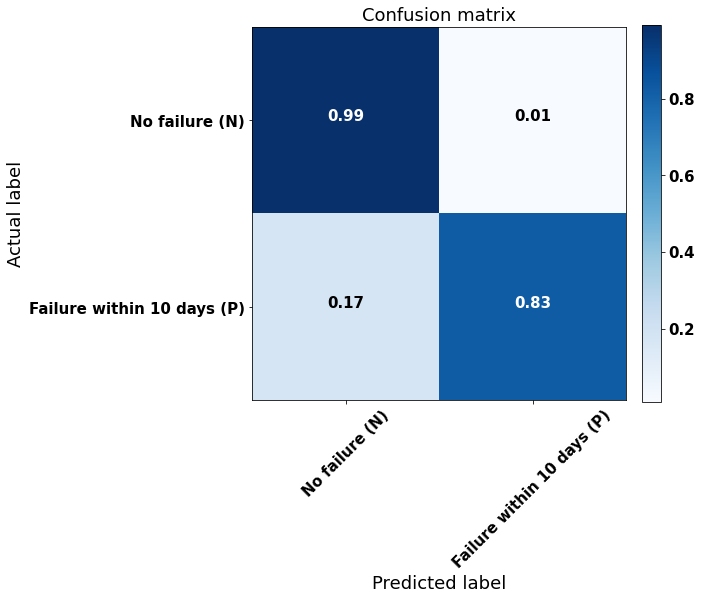

In [40]:
plot_confusion_matrix(
    confusionMatrix,
    normalize=True,
    classes=["No failure (N)", "Failure within 10 days (P)"],
)

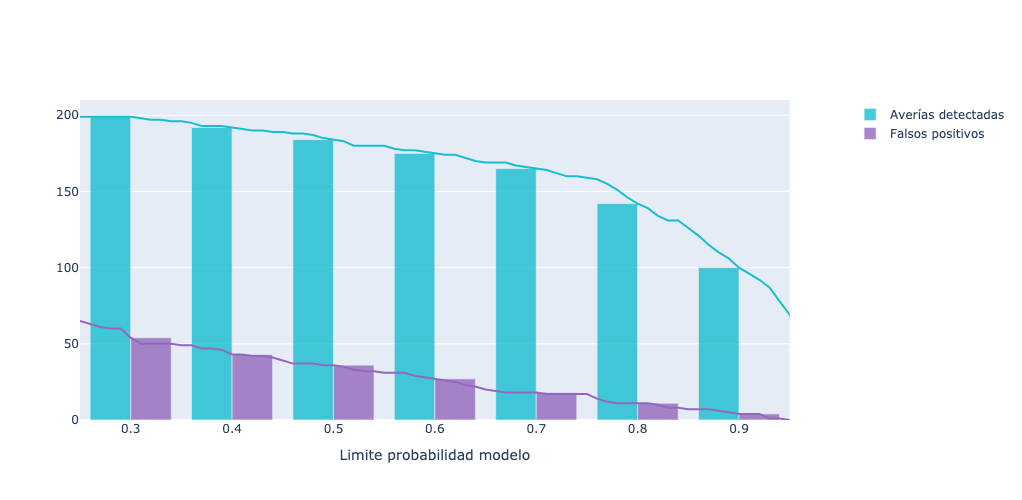

In [44]:
from plotly.subplots import make_subplots


def display_tp(thres, tp, fp, title="", fig=None, i=0, name1="", name2=""):

    colors = [
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
        "#9467bd",  # muted purple
        "#8c564b",  # chestnut brown
        "#e377c2",  # raspberry yogurt pink
        "#7f7f7f",  # middle gray
        "#bcbd22",  # curry yellow-green
        "#17becf",  # blue-teal
    ]
    hovertext = [
        f"TP: {r}<br>FP: {p}<br>Thres: {t:.2f}" for r, p, t in zip(tp, fp, thres)
    ]

    # ROC curve Train
    lw = 2
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    opacity = 0.8

    ## PRecision
    fig.add_trace(
        go.Bar(
            x=thres[::10],
            y=tp[::10],
            name=name1,
            hovertext=hovertext[::10],
            hoverinfo="text",
            marker_color=colors[9],
            opacity=opacity,
            xaxis="x1",
            yaxis="y1",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=thres,
            y=tp,
            mode="lines",
            name=name1,
            hovertext=hovertext,
            hoverinfo="text",
            line=dict(color=colors[9]),
            showlegend=False,
            xaxis="x1",
            yaxis="y1",
        ),
        secondary_y=False,
    )

    ## recall curve
    fig.add_trace(
        go.Bar(
            x=thres[::10],
            y=fp[::10],
            #             mode="lines",
            name=name2,
            hovertext=hovertext[::10],
            hoverinfo="text",
            marker_color=colors[4],
            opacity=opacity,
            xaxis="x1",
            yaxis="y1",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=thres,
            y=fp,
            mode="lines",
            name=name2,
            hovertext=hovertext,
            hoverinfo="text",
            line=dict(color=colors[4]),
            showlegend=False,
            xaxis="x1",
            yaxis="y1",
        ),
        secondary_y=False,
    )

    fig.update_yaxes(title_text="")
    fig.update_xaxes(title_text="Limite probabilidad modelo")
    fig.update_yaxes(range=[0, 210])
    fig.update_xaxes(range=[0.25, 0.95])

    fig.update_layout(height=500)

    return fig


fig = display_tp(
    thres=metrics["thres"],
    tp=metrics["tp"],
    fp=metrics["fp"],
    title="",
    fig=None,
    i=0,
    name1="Averías detectadas",
    name2="Falsos positivos",
)
# plotly.offline.plot(fig, filename='reports/comparativa_metricas.html')
fig

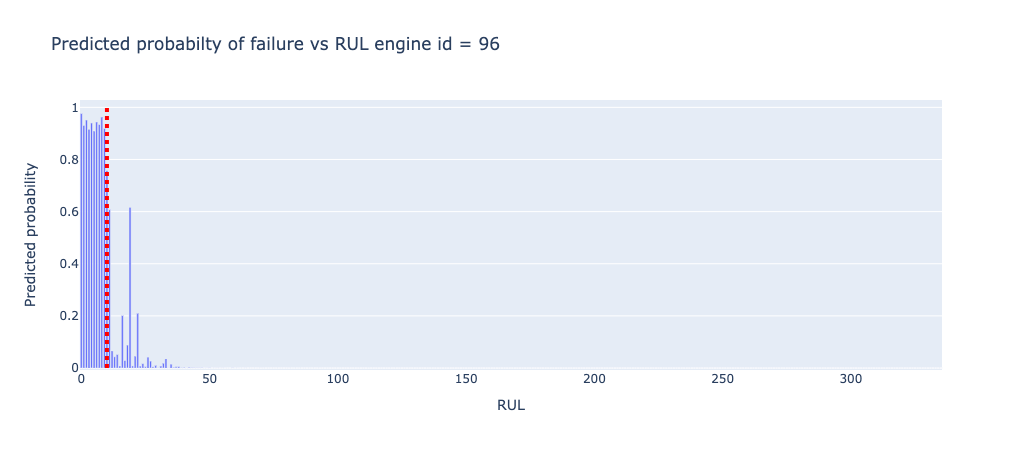

In [116]:
y_train_pred = estim_grid_clf.best_model.predict_proba(
    df_train_proc2.drop(["RUL", "id", "RUL_thres"], axis=1)
)[:, 1]
df_plot = pd.DataFrame(
    {
        "y_train": df_train_proc2.RUL,
        "y_train_pred": y_train_pred,
        "id": df_train_proc2.id,
    }
)

# Create traces
fig = go.Figure()

engine = 96
idx = df_plot.id == engine
df_plot_filter = df_plot[idx]

fig.add_trace(
    go.Bar(
        x=df_plot_filter["y_train"],
        y=df_plot_filter["y_train_pred"],
        name=f"Enigne {engine}",
    )
)
fig.add_shape(
    type="line", x0=10, y0=0, x1=10, y1=1, line=dict(width=4, dash="dot", color="red")
)
fig.update_layout(
    title=f"Predicted probabilty of failure vs RUL engine id = {engine}",
    xaxis_title="RUL",
    yaxis_title="Predicted probability",
)
fig.show()

# 